# Example 03: Logistic Regression with Higher-Level APIs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch.optim import SGD
from torch.utils.data import (
    TensorDataset, 
    DataLoader,
    random_split,
)
from sklearn.datasets import make_blobs
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [2]:
np.random.seed(1337)
torch.manual_seed(1337)

## 0. Toy Dataset Generation

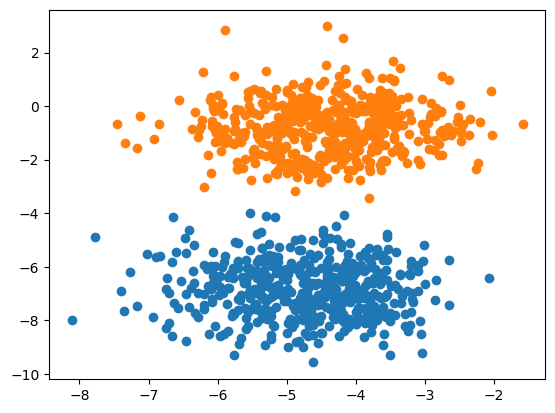

In [3]:
num_features = 2
num_examples = 1000

# toy data generation
w_true = torch.tensor([0.5, -2], dtype=torch.float32)
b_true = torch.tensor([1], dtype=torch.float32)

x_total, t_total = make_blobs(
    n_samples=num_examples, 
    n_features=num_features, 
    centers=2,
    random_state=1337
)

fig, ax = plt.subplots()
ax.scatter(x_total[t_total == 0, 0], x_total[t_total == 0, 1], color='tab:blue')
ax.scatter(x_total[t_total == 1, 0], x_total[t_total == 1, 1], color='tab:orange')

In [4]:
x_total = torch.from_numpy(x_total).float()
t_total = torch.from_numpy(t_total).long()

dataset = TensorDataset(x_total, t_total)
train_set, val_set, test_set = random_split(dataset, lengths=[0.64, 0.16, 0.2])

## 1. Model

- `torch.nn.Sequential`: `torch.nn.Sequential is a container module in PyTorch that allows you to build neural networks by stacking layers in the order they are defined. It automatically passes the output of one layer as the input to the next. This makes it easy to create simple feedforward models without writing a custom forward method. See https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html
- `torch.nn.Sigmoid`: https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html

In [5]:
# linear transformation + bias addition
model = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=1, bias=True),
    nn.Sigmoid(),
)

In [6]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


## 2. Optimisation Criterion: Cross Entropy
- Cross‐entropy (CE) is the loss function that measures how well the model’s predicted probability distribution $p$ matches the true distribution $q$ (the labels)
$$ \Large H(p,q) = -\mathbb{E}_{q} [\log{p}] $$
- CE penalizes the model for assigning low probability to the correct class—if the model is confident and correct ($p\approx 1$), the loss is near zero; if it’s confident and wrong ($q \approx 0$), the loss becomes very large
- Minimizing cross‐entropy is equivalent to maximizing the (log) likelihood of the training data under the model’s predicted distribution, which leads to better‐calibrated probability estimate
- Empirical binary cross entropy:
$$\Large \textrm{BCELoss}(\textrm{prediction}=y, \textrm{target}=t) = - \left( t \log{y} + (1 - t) \log{1 - y} \right)$$,
  - where $\large y \sim p $ and $\large t \sim q$
- https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
- https://en.wikipedia.org/wiki/Cross-entropy

In [7]:
# binary cross entropy
criterion = nn.BCELoss(reduction='mean')

## 3. Optimizer: Stochastic Gradient Descent

In [8]:
optimizer = SGD(params=model.parameters(), lr=0.1)

## 4. DataLoader for batch training 

In [9]:
# DataLoader for training: shuffles data
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True,
    drop_last=True, # drop last incomplete batch if any
)

# DataLoader for validation: no shuffling, keep all data
val_loader = DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
)

## 5. Fit

In [10]:
def plot_curve(
    train_loss_step, 
    train_loss,
    train_acc_step,
    train_acc,
    val_step,
    val_loss,
    val_acc,
) -> None:
    """
    """
    clear_output(wait=True)
    fig, (ax_loss, ax_acc) = plt.subplots(figsize=(10, 5), ncols=2)
    
    ax_loss.plot(train_loss_step, train_loss, label='Training', ls=':', marker='o')
    ax_loss.plot(val_step, val_loss, label='Validation', ls='--', marker='s')
    ax_loss.set_xlabel(r'Step')
    ax_loss.set_ylabel(r'Binary Cross Entropy')
    ax_loss.legend()

    ax_acc.plot(train_acc_step, train_acc, label='Training', ls=':', marker='o')
    ax_acc.plot(val_step, val_acc, label='Validation', ls='--', marker='s')
    ax_acc.set_xlabel(r'Epoch')
    ax_acc.set_ylabel(r'Accuracy')
    ax_acc.legend()
    
    display(fig)
    plt.close(fig)

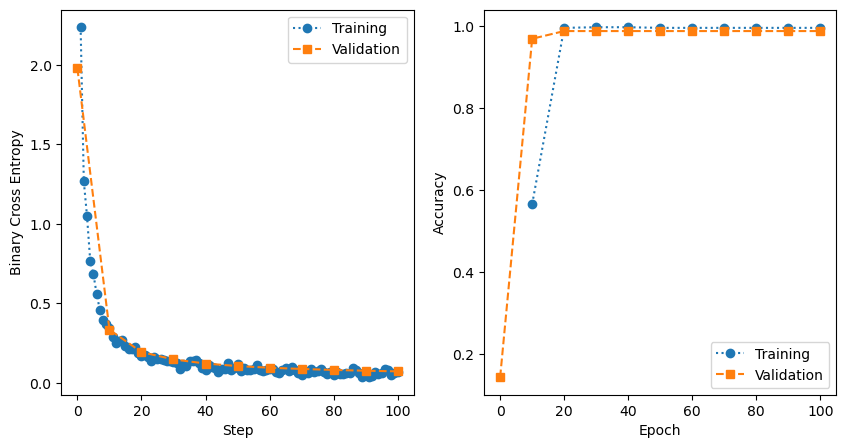

In [11]:
# prepare lists for plotting
train_loss_step_list = []
train_loss_list = []

train_acc_step_list = []
train_acc_list = []

val_step_list = []
val_loss_list = []
val_acc_list = []

step = 0

max_epochs = 10
threshold = 0.5

for epoch in range(0, max_epochs + 1):

    if epoch > 0:
        # training
        train_correct = 0
        for x, t in train_loader:
            y_score = model(x).squeeze() # forward pass
            loss = criterion(input=y_score, target=t.float()) # compute loss
            loss.backward() # backpropagate
            optimizer.step() # update weights
            optimizer.zero_grad() # reset gradients

            step += 1

            y_pred = y_score >= threshold
            train_correct += (y_pred == t).sum().item()

            train_loss_step_list.append(step)
            train_loss_list.append(loss.item())

        train_acc_step_list.append(step)
        train_acc_list.append(train_correct / len(train_set))
    
    # validation
    val_loss_sum = 0
    val_correct = 0
    with torch.no_grad(): # disable gradient computation for validation
        for x, t in val_loader:
            y_score = model(x).squeeze()
            loss = criterion(input=y_score, target=t.float())
            y_pred = y_score >= threshold

            val_loss_sum += loss.item() * len(x)
            val_correct += (y_pred == t).sum().item()

    val_step_list.append(step)
    val_loss_list.append(val_loss_sum / len(val_set))
    val_acc_list.append(val_correct / len(val_set))

    plot_curve(train_loss_step_list, train_loss_list, train_acc_step_list, train_acc_list, val_step_list, val_loss_list, val_acc_list)

## 4. Testing and Receiver-operating characteristic (ROC) curve

### Receiver Operating Characteristic (ROC) Curve

**Objective:**  
Understand and visualize the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) for a binary classifier.

---

#### 1. Confusion Matrix

|                   | Predicted Positive | Predicted Negative |
|-------------------|--------------------|--------------------|
| **Actual Positive** | True Positive (TP)  | False Negative (FN) |
| **Actual Negative** | False Positive (FP) | True Negative (TN)  |

---

#### 2. Key Metrics

- **True Positive Rate (TPR)**  
  $$ \displaystyle \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

- **False Positive Rate (FPR)**  
  $$ \displaystyle \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}} $$

- **True Negative Rate (FPR)**  
  $$ \displaystyle \text{TNR} = \frac{\text{TN}}{\text{FP} + \text{TN}} =  1 - \text{FPR}$$


---

#### 3. ROC Curve

- The **ROC Curve** plots TPR vs. FPR (or TNR) across different classification thresholds
- An ideal classifier passes through the point (0, 1) (FPR = 0, TPR = 1)

---

#### 4. AUC (Area Under the Curve)

- **AUC** measures the area under the ROC curve.  
- **0.5:** No discrimination (random guessing)  
- **1.0:** Perfect discrimination

---

#### 5. References
- https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [12]:
test_loader = DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False,
    drop_last=False,
)

In [13]:
# scikit-learn notation
y_score_arr = []
y_true_arr = []

model.eval()
with torch.inference_mode(): # disable gradient computation for validation
    for x, t in test_loader:
        y_logits = model(x).squeeze()
        y_score = y_logits.sigmoid()

        y_score_arr.append(y_score.numpy())
        y_true_arr.append(t.numpy())

y_score_arr = np.concatenate(y_score_arr)
y_true_arr = np.concatenate(y_true_arr)

In [14]:
fpr, tpr, threshold_arr = metrics.roc_curve(
    y_true=y_true_arr,
    y_score=y_score_arr,
)

tnr = 1 - fpr

In [15]:
roc_auc = metrics.auc(tpr, tnr)

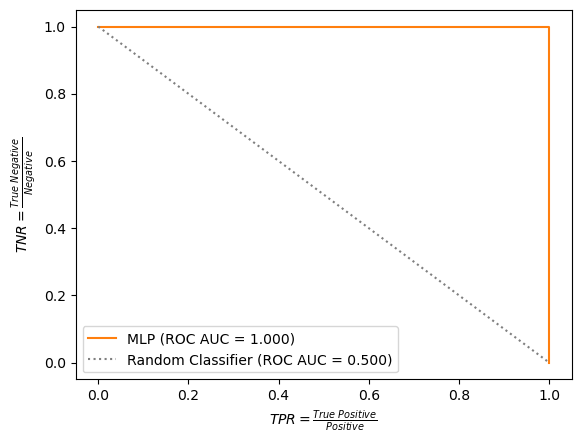

In [16]:
fig, ax = plt.subplots()
ax.plot(tpr, tnr, label=f'MLP (ROC AUC = {roc_auc:.3f})', color='tab:orange')
ax.plot([0, 1], [1, 0], label='Random Classifier (ROC AUC = 0.500)', color='tab:gray', ls=':')
ax.set_xlabel(r'$TPR=\frac{True\ Positive}{Positive}$')
ax.set_ylabel(r'$TNR=\frac{True\ Negative}{Negative}$')
ax.legend()